<a href="https://colab.research.google.com/github/delemarchand2020/IVADO_MILA_DL/blob/main/Predict_FX_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projet d'utilisation des modèles RNN pour la prédiction des taux de change et comparaison avec le modèle de marche aléatoire

Pour les besoins de ce projet, on récupère les historiques journaliers des taux de change des 10 principales devises depuis 1980, on bâtit des séquences de 7 jours consécutifs dont la cible à prédire est le 8 ieme jour. On utilise une technique de "bootstrap" pour faire des prédictions, par la suite, sur plusieurs jours : à partir d'une séquence initiale de 7 jours, on prévoit le 8 iéme jour avec RNN puis on soumet au RNN une nouvelle séquence de 7 jours incluant la dernière prévision effectuée et de proche en proche on effectue des prévisions sur 2, 3, ... n jours.

Le RNN est alimenté en apprentissage avec de telles séquences sur N devises et du point de vue du RNN, on suppose que ces devises suivent le même processus. Dès lors, on pourra effectuer des prévisions sur n'importe quelle série chronologique suivant ce même processus.

Pour comparer nos prévisions et évaluer la performance de prévision du RNN, on considére les 2 modèles de références suivants: 


>(1) "random walk" : la prévision du 8 ième jour est le taux de change observé le 7 ième jour (c'est le modèle de marche aléatoire). Ce modèle dit que la meilleure prévision du taux de change dans le futur (1, 2, ... ou 7 jours) est le taux de change qui prévaut aujourd'hui. En d'autres termes, le meilleur estimateur du taux futur est le taux comptant prévalant.

>(2) moyenne mobile : la prévision du 8 ième jour est la moyenne des taux des 7 derniers jours. 

Ces 2 modèles ne requierent aucune autre information contextuelle.

Le Mean-Squared-Error, écart entre la valeur réellement observée et la prévision des différents modèles ("random walk", moyenne mobile, RNN), donnera une bonne indication de la performance relative des modèles étudiés.

Dans la littérature en finance internationale, il est connu que le modèle de marche aléatoire (modèle 1) est très difficile à battre. 

Est-ce que le RNN aura de la difficulté à le battre également ? C'est la question à laquelle ce projet tente de répondre.

**Notes :**

>(a) quelques portions de code ont été copié des tutoriaux du MILA (cours IVADO/MILA DeepLearning 2021).
Voir les sources [ici](https://github.com/mila-iqia/ivado-mila-dl-school-2021/tree/main/tutorials).

>(b) références des articles IA/DL: 
- https://www.researchgate.net/publication/315415407_Deep_networks_for_predicting_direction_of_change_in_foreign_exchange_rates
- https://towardsdatascience.com/stock-prediction-using-recurrent-neural-networks-c03637437578
- https://pub.towardsai.net/bitcoin-price-prediction-with-rnn-and-lstm-in-python-f912d57c483e

>(c) références des articles de finance:
- [Meese & Rogoff (1983)](http://lien.uqam.ca/YjOACsY)
- [Rossi (2013)](http://lien.uqam.ca/fXxa052)
- [Engel, Mark & West (2012)](http://www.nber.org/papers/w18382.pdf)

# Initialisation

In [ ]:
!pip3 install torch

In [ ]:
import torch

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

print("Torch version: ", torch.__version__)
print("GPU Available: {}".format(use_gpu))

Torch version:  1.8.1+cu101
GPU Available: True


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import copy
import gc
import math
import time
import os

# Import et préparation des données

## Chargement du fichier et nettoyage des données


In [ ]:
url_data_source = 'https://github.com/delemarchand2020/IVADO_MILA_DL/raw/main/FX_HFData.xlsx'
df = pd.read_excel(url_data_source, sheet_name='Daily All',dtype={' ': datetime.date, 'USDCAD Curncy': float, 'EURUSD Curncy': float, 'GBPUSD Curncy': float})
df = df.drop(columns=['USDJPY Curncy','USDCHF Curncy',
                      'AUDUSD Curncy','USDSEK Curncy','USDNOK Curncy','NZDUSD Curncy','USDSGD Curncy'])
df = df.dropna()
df.columns = ['date', 'USDCAD','EURUSD', 'GBPUSD']
df.describe()

,USDCAD,EURUSD,GBPUSD
count,10640.000000,10640.000000,10640.000000
mean,1.264089,1.171747,1.612382
std,0.150234,0.175962,0.229712
min,0.920350,0.644370,1.052000
25%,1.163687,1.080858,1.474000
50%,1.270245,1.181470,1.589745
75%,1.364800,1.297900,1.722500
max,1.613500,1.599130,2.446000


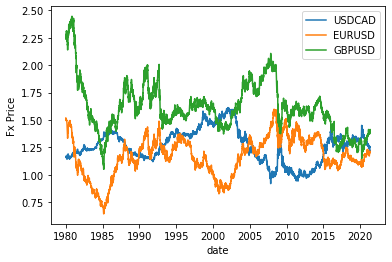

In [ ]:
plt.figure()
plt.plot(df['date'],df['USDCAD'], label='USDCAD')
plt.plot(df['date'],df['EURUSD'], label='EURUSD')
plt.plot(df['date'],df['GBPUSD'], label='GBPUSD')
plt.xlabel('date')
plt.ylabel('Fx Price')
plt.legend()

## Création des datasets (train, validate et test)

In [ ]:
seq_len = 8 # 7 premiers sont les séquences d'entrée et le huitieme est la cible à prédire
s = pd.Series(df['USDCAD'].values) # USDCAD ou EURUSD ou GBPUSD

arr = [s.shift(x).values[::-1][:seq_len] for x in range(len(s))[::-1]]
dfs = []
for row in arr:
  dfs.append(row[::-1])
dfs = dfs[seq_len-1:]

On divise le dataset en 3 parties:

<ol>
<li> <b> Train</b> (60% du dataset): utilisé pour entraîner le modèle. </li>   
<li> <b> Validation</b> (20% du dataset): utilisé pour évaluer les "hyper-parameters", c'est à dire les paramètres intrinsèques au bon apprentissage. </li>   
<li> <b> Test</b> (20% du dataset): utilisé pour évaluer la généralisation de la performance sur des données hors apprentissage. </li>
</ol>

In [ ]:
train, validate, test = np.split(dfs, [int(.6*len(dfs)), int(.8*len(dfs))])

Dans les 2 sections suivantes, on créé les séquences d'entrées et de sorties telles que les 7 premiers prix journaliers sont les séquences d'entrée et le huitieme est la cible à prédire !

Dans les 2 suivantes, on "standardise" les jeux de données pour faciliter l'apprentissage RNN.

In [ ]:
def split_x_y_in_torch(dfs):
  X = []
  Y = []
  for row in dfs:
    X.append([row[0:seq_len-1]])
    Y.append([row[seq_len-1]])
  X = np.array(X)
  Y = np.array(Y)
  return torch.from_numpy(X.transpose(0,2,1)).float(), torch.from_numpy(Y).float()

In [ ]:
X_train, y_train = split_x_y_in_torch(train)
X_validate, y_validate = split_x_y_in_torch(validate)
X_test, y_test = split_x_y_in_torch(test)

In [ ]:
def standardize(X, mean=None, std=None):
    """The function standardizes the X tensor. 
    Args:
      X: torch.Tensor.
    
    Returns:
      Xs: torch.Tensor standardize.
      mean: float, the mean of X.
      stdev: float, the stdev of X.
    """
    
    X=X.float()

    if mean == None:
      mean = torch.mean(X)
    if std == None:
      std = torch.std(X)
      
    Xs = (X-mean) / std

    return Xs, mean, std

In [ ]:
mean = np.mean(dfs)
std = np.std(dfs)

Xs_train, Xs_train_mean, Xs_train_std = standardize(X_train, mean, std)
ys_train, ys_train_mean, ys_train_std = standardize(y_train, mean, std)

Xs_validate, Xs_validate_mean, Xs_validate_std = standardize(X_validate, mean, std)
ys_validate, ys_validate_mean, ys_validate_std = standardize(y_validate, mean, std)

Xs_test, Xs_test_mean, Xs_test_std = standardize(X_test, mean, std)
ys_test, ys_test_mean, ys_test_std = standardize(y_test, mean, std)

# Implémentation du modèle RNN

## Modèle RNN
Implementation d'un modèle RNN en utilisant [torch.nn.RNN()](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) class. Les paramètres en entrée sont:
- **input_dim**: la dimension des données en entrée (dans notre cas, ce sera un scalaire donc input_dim = 1)
- **output_dim**: la dimension des données en sortie (nous voulons une prédiction qui est aussi un scalaire, donc output_dim = 1)
- **hidden_size**: la taille des couches internes du RNN. C'est un paramètre à "fine tuner".
- **n_layers**: le nombre de couche du RNN. C'est également un paramètre à "fine tuner".

### Définition du modèle RNN

>**Note:** extrait des tutoriaux du MILA

In [ ]:
class RNNLinear(nn.Module):

    def __init__(self, input_dim, output_dim, hidden_size, n_layers):
        super(RNNLinear, self).__init__()
        self.rnn_layer = torch.nn.RNN(input_size=input_dim,hidden_size=hidden_size,num_layers=n_layers)
        self.linear_layer = torch.nn.Linear(in_features=hidden_size,out_features=output_dim)
        self.print_debug_flag = False

    def print_debug(self,text,var):
      if self.print_debug_flag == True:
        print(text,var)

    def forward(self, x):
        # x has size of (n_samples=batch_size, seq_len, input_dim)
        # The RNN's input must be of size (seq_len, batch_size, input_dim)
        self.print_debug('x:',x)

        x = torch.transpose(x, 0, 1)

        self.print_debug('x\':',x)

        output, hidden = self.rnn_layer(x) #hidden c'est le dernier h (vecteur)
                                            # si on veut initialiser un autre rnn avec les parametres déjà appris

        self.print_debug('hidden:',hidden)
        self.print_debug('output:',output)
        self.print_debug('output[-1]:',output[-1])
        self.print_debug('linear_layer(output):',self.linear_layer(output))
        self.print_debug('linear_layer(output[-1]):',self.linear_layer(output[-1]))

        output = output[-1]
        pred = self.linear_layer(output)
        
        self.print_debug('pred:',pred)

        return pred

### Instanciation du modèle

>**Note:** extrait des tutoriaux du MILA

> **ATTENTION** : si l'on souhaite faire du pre-tranining avec plusieurs devises, pensez à mettre *rnn_weights =  previous_rnn_weights*, sinon le RNN partira avec des poids initiaux aléatoires.

In [ ]:
input_dim = 1
output_dim = 1
n_layers = 2
hidden_size = 20

# Declaration of the RNN model
model_rnn = RNNLinear(input_dim, output_dim, hidden_size, n_layers)

# Transfer the model to the proper device
model_rnn = model_rnn.to(device)

# save its initial weights (we do this so that, if we run the model
# multiple time, we always start from these randomly initialized weights)
init_rnn_weights = copy.deepcopy(model_rnn.state_dict())

# pre-training : on repart de previous_rnn_weights sinon init_rnn_weights
rnn_weights =  init_rnn_weights #init_rnn_weights #previous_rnn_weights

### Test du modèle avant apprentissage (inital ou suite au pre-training)

In [ ]:
# Transfer the data to the proper device
Xs_train = Xs_train.to(device)

# Use the RNN to predict the output of each input sequence prior to training
# Ensure that the inputs and output are correct
y_pred = model_rnn(Xs_train)
print("Size of input data: {}".format(Xs_train.shape)) # (n_samples, seq_len, input_dim)
print("Size of predictions: {}".format(y_pred.shape)) # (n_samples, input_dim)
        
# x has size of (n_samples=batch_size, seq_len, input_dim)
# The RNN's input must be of size (seq_len, batch_size, input_dim)
print(Xs_train.shape)
Xs_train_t = torch.transpose(Xs_train, 0, 1)
print(Xs_train_t.shape)
print(ys_train[1])
print(y_pred[1])

Size of input data: torch.Size([6379, 7, 1])
Size of predictions: torch.Size([6379, 1])
torch.Size([6379, 7, 1])
torch.Size([7, 6379, 1])
tensor([-0.6511])
tensor([0.0720], device='cuda:0', grad_fn=<SelectBackward>)


## Création des "data loader"
Cela utilise les objets DataLoader PyTorch pour manipuler plus facilement et efficacement nos données.
>**Note:** extrait des tutoriaux du MILA

In [ ]:
batch_size = 4

# dataloader for the training dataset
train_loader = DataLoader(TensorDataset(Xs_train, ys_train), batch_size, shuffle=True)

# prepare the dataloader for the validation dataset
valid_loader = DataLoader(TensorDataset(Xs_validate, ys_validate), batch_size)

# prepare the dataloader for the test dataset
test_loader = DataLoader(TensorDataset(Xs_test, ys_test), batch_size)

## Boucle d'apprentissage



>**Note:** extrait des tutoriaux du MILA



In [ ]:
learning_rate = 0.01

# Define the loss function
loss_fun = torch.nn.MSELoss()

# Define the Optimizer
def get_optimizer(model):
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  return optimizer

In [ ]:
# Define function to encapsulate main training loop
def train_model(model, init_weights, optimizer):

    since = time.time()

    train_loss_history = []
    valid_loss_history = []

    n_epoch = 25

    model.load_state_dict(init_weights)

    print("Start training")

    for epoch in range(n_epoch):
        
        train_loss = 0
        train_n_iter = 0
        
        # Set model to train mode
        model.train()
        torch.set_grad_enabled(True)
        
        # Iterate over train data
        for x, y in train_loader:  

            
            # Put tensors on device (GPU when available)
            x = x.to(device)
            y = y.to(device)

            # Zero the gradient buffer
            optimizer.zero_grad()
            
            # Perform the Forward operation
            outputs = model(x)
            
            # Calculate the loss using the loss function
            loss = loss_fun(outputs, y)
            
            # Perform the Backward operation
            loss.backward()
            
            # Perform the Optimization step
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            train_n_iter += 1
        
        valid_loss = 0
        valid_n_iter = 0
        
        # Set model to evaluate mode
        model.eval()
        with torch.no_grad():
        
            # Iterate over valid data
            for x, y in valid_loader:  
            
                # Put tensors on device (GPU when available)
                x = x.to(device)
                y = y.to(device)
            
                # Perform the Forward operation
                outputs = model(x)
                
                # Calculate the loss using the loss fun function
                loss = loss_fun(outputs,y)
            
                # Statistics
                valid_loss += loss.item()
                valid_n_iter += 1
        
        train_loss_history.append(train_loss / train_n_iter)
        valid_loss_history.append(valid_loss / valid_n_iter)


        print("Epoch {:2d} | Training loss = {:.5f} | Validation loss = {:.5f} "
              .format(epoch+1, (train_loss / train_n_iter), (valid_loss / valid_n_iter)))

    time_elapsed = time.time() - since

    print('\n\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return train_loss_history, valid_loss_history

C'est dans la portion suivante que l'on gére le pre-training ou que l'on relance un apprentissage initial.

*Voir le commentaire # pre-training dans le code d'instanciation du modèle RNN.*

In [ ]:
# Perform training of the RNN model
optimizer_rnn = get_optimizer(model_rnn)

loss_history = train_model(model_rnn, rnn_weights, optimizer_rnn)

# Save loss history for later
rnn_train_loss_history, rnn_valid_loss_history = loss_history

# Save weights for later pre-training
previous_rnn_weights = copy.deepcopy(model_rnn.state_dict())

Start training
Epoch  1 | Training loss = 0.01499 | Validation loss = 0.08985 
Epoch  2 | Training loss = 0.00152 | Validation loss = 0.04424 
Epoch  3 | Training loss = 0.00125 | Validation loss = 0.03609 
Epoch  4 | Training loss = 0.00116 | Validation loss = 0.02864 
Epoch  5 | Training loss = 0.00113 | Validation loss = 0.02414 
Epoch  6 | Training loss = 0.00113 | Validation loss = 0.02394 
Epoch  7 | Training loss = 0.00110 | Validation loss = 0.02280 
Epoch  8 | Training loss = 0.00110 | Validation loss = 0.02281 
Epoch  9 | Training loss = 0.00107 | Validation loss = 0.02066 
Epoch 10 | Training loss = 0.00106 | Validation loss = 0.02436 
Epoch 11 | Training loss = 0.00106 | Validation loss = 0.02085 
Epoch 12 | Training loss = 0.00105 | Validation loss = 0.02047 
Epoch 13 | Training loss = 0.00104 | Validation loss = 0.02025 
Epoch 14 | Training loss = 0.00102 | Validation loss = 0.02064 
Epoch 15 | Training loss = 0.00101 | Validation loss = 0.01636 
Epoch 16 | Training loss 

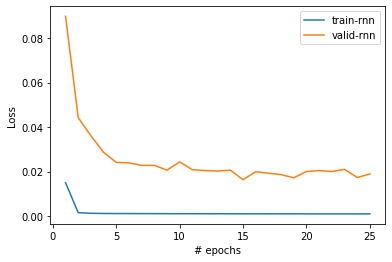

In [ ]:
# Plot training and validation curve
n_epoch = 25
xaxis = range(1, n_epoch + 1)
plt.plot(xaxis, rnn_train_loss_history, label='train-rnn')
plt.plot(xaxis, rnn_valid_loss_history, label='valid-rnn')

plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Validation pré-production du modèle

In [ ]:
def print_mean_abs_error(X, Y, idx=None):
    xs = X.numpy()
    ys = Y.numpy()

    if idx == None:
      diff = abs(xs-ys)
      print(f"Absolute mean error between target[:] et prediction[:] = {np.mean(diff)}")
    else:
      diff = abs(xs[idx]-ys[idx])
      print(f"Absolute mean error between target[{idx}] et prediction[{idx}] = {np.mean(diff)}")

## Validation avec le dataset de tests au complet

The RNN's test mean squared error is 0.003


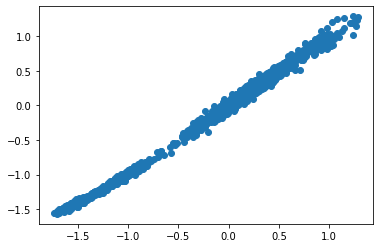

In [ ]:
# Put sequence data on device (GPU when available)
Xs_test = Xs_test.to(device)

# Put target data on device (GPU when available)
ys_test = ys_test.to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(Xs_test)

# Compute the loss of the RNN-based model using the loss function
loss_test_rnn = loss_fun(ypred_rnn, ys_test)

print(f"The RNN's test mean squared error is {float(loss_test_rnn):2.3f}")

plt.scatter(ys_test.cpu().detach().numpy(),ypred_rnn.cpu().detach().numpy())

Dans la section suivante on affiche une prédiction de prix.

On affiche aléatoirement la prévision pour l'un des éléments du jeu de test.

In [ ]:
Xs_test = Xs_test.cpu()
ypred_rnn = ypred_rnn.cpu()
ys_test = ys_test.cpu()

# Unstandardize  xtest ytest
xtest_unstd = Xs_test*std + mean

ys_test_unstd = ys_test*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + mean

# sample a random number from the examples above:
idx = np.random.randint(len(ys_test))

print("")
print("Example RNN:")
print("")
print(f"xtest[{idx}] = {xtest_unstd.detach()[idx]}")
print(f"ys_test[{idx}] = {ys_test_unstd.detach()[idx]}\n ypred[{idx}] = {ypred_unstd.detach()[idx]}")

print_mean_abs_error(ys_test_unstd.detach(), ypred_unstd.detach(), idx)
print_mean_abs_error(ys_test_unstd.detach(), ypred_unstd.detach())


Example RNN:

xtest[1809] = tensor([[1.3252],
        [1.3235],
        [1.3260],
        [1.3221],
        [1.3260],
        [1.3225],
        [1.3293]])
ys_test[1809] = tensor([1.3279])
 ypred[1809] = tensor([1.3268])
Absolute mean error between target[1809] et prediction[1809] = 0.0011039972305297852
Absolute mean error between target[:] et prediction[:] = 0.006048618815839291


## Validation avec des séquences unitaires

Dans la section suivante on affiche une prédiction de prix.

On affiche la prévision pour l'un des éléments du jeu de test (en fixant idx). 

**Identique à la section précédente (à fusionner plus tard).**

In [ ]:
idx = 0

# Put sequence data on device (GPU when available)
Xs_unit = Xs_test[idx:idx+1,:,:].to(device)

# Put target data on device (GPU when available)
ys_unit = ys_test[idx].to(device)

# Predict the value of the sequence data using the RNN-based model
ypred_rnn = model_rnn(Xs_unit)

Xs_unit = Xs_unit.cpu()
ypred_rnn = ypred_rnn.cpu()
ys_unit = ys_unit.cpu()

# Unstandardize  xtest ytest
xunit_unstd = Xs_unit*std + mean

ys_unit_unstd = ys_unit*std + mean

# Unstandardize  the predictions of the RNN-based model on xtest
ypred_unstd = ypred_rnn*std + mean

print(f"xunit[{idx}] = {xunit_unstd.detach()[0,:,0]}")
print(f"ys_unit[{idx}] = {ys_unit_unstd.detach()}\n ypred[{idx}] = {ypred_unstd.detach()}")

print_mean_abs_error(ys_unit_unstd.detach(), ypred_unstd.detach())

xunit[0] = tensor([1.0259, 1.0257, 1.0276, 1.0222, 1.0194, 1.0222, 1.0267])
ys_unit[0] = tensor([1.0260])
 ypred[0] = tensor([[1.0442]])
Absolute mean error between target[:] et prediction[:] = 0.018191933631896973


## Prédiction sur n jours suivants

In [ ]:
def shif_right_and_complete(input_seq, item_to_add, debug=False):
  if debug == True:
    print(input_seq[0,:,0])
    print(item_to_add[0])
    print("--------------------")
  output = input_seq[:,1:7,:]
  output = torch.cat((output, item_to_add.unsqueeze(2)),dim=1)
  if debug == True:
    print(output[0,:,0])
  return output

Xs_unit_1 = shif_right_and_complete(Xs_unit.detach(), ypred_rnn.detach(), debug=True)
idx = 102
Xs_test[idx:idx+1,:,0]
Xs_test[idx:idx+2,:,0]
Xs_test[idx:idx+3,:,0]

tensor([-1.5855, -1.5871, -1.5744, -1.6100, -1.6288, -1.6104, -1.5798])
tensor([-1.4637])
--------------------
tensor([-1.5871, -1.5744, -1.6100, -1.6288, -1.6104, -1.5798, -1.4637])


tensor([[-1.5736, -1.5272, -1.4966, -1.5181, -1.5073, -1.4761, -1.5393],
        [-1.5272, -1.4966, -1.5181, -1.5073, -1.4761, -1.5393, -1.5658],
        [-1.4966, -1.5181, -1.5073, -1.4761, -1.5393, -1.5658, -1.5533]])

In [ ]:
def prediction_n_jours(inputs, targets, mean, std, n=7, idx=1500, display=False, bootstrap=True):
  Xs_unit = inputs[idx:idx+1,:,:]
  ys_targets = np.array([])
  ys_predicts = np.array([])
  ys_model1 = np.ones(n)*targets.numpy()[idx-1]
  ys_model2 = np.ones(n)*torch.mean(Xs_test[idx-1:idx,:,:]).numpy()

  for i in range(idx,idx+n):
    Xs_unit = Xs_unit.to(device)
    ypred_rnn = model_rnn(Xs_unit)
    ys_targets = np.append(ys_targets,targets.numpy()[i])
    ys_predicts = np.append(ys_predicts, ypred_rnn.cpu().detach().numpy()[0])
    if bootstrap == True:
      Xs_unit = shif_right_and_complete(Xs_unit.detach(), ypred_rnn.detach())

  y_targets = ys_targets*std + mean
  y_predicts = ys_predicts*std + mean
  y_model1 =  ys_model1*std + mean
  y_model2 =  ys_model2*std + mean

  y_previous = targets.numpy()[idx-7:idx,0]*std + mean

  rnn_mse = np.mean(np.power((y_predicts - y_targets),2))
  model1_mse = np.mean(np.power((y_model1 - y_targets),2))
  model2_mse = np.mean(np.power((y_model2 - y_targets),2))

  # prediction sur le sens de la tendance (haussière ou baissière)
  # dans les cas des 2 modèles standards, ce n'est pas possible
  target_direction = np.sign(y_targets[-1] - y_previous[-1])
  predict_direction = np.sign(y_predicts[-1] - y_previous[-1])

  if display == True:
    print(y_targets)
    print(y_predicts)

    xaxis = range(1, 8)
    plt.plot(xaxis, y_previous, label='past 7 days')

    start = 8
    xaxis_pred = range(start, start+n)
    plt.plot(xaxis_pred, y_targets, label='targets (real)')
    plt.plot(xaxis_pred, y_predicts, label=f'RNN (mse={rnn_mse})')
    plt.plot(xaxis_pred, y_model1, label=f'Std model1 (mse={model1_mse})')
    plt.plot(xaxis_pred, y_model2, label=f'Std model2 (mse={model2_mse})')

    plt.xlabel('# jours')
    plt.ylabel('Fx Price')
    plt.title(f'Predictions idx={idx}')
    plt.legend()

    plt.show()
  
  return rnn_mse, model1_mse, model2_mse, (predict_direction == target_direction)

### Quelques courbes et résultats pour les prédictions sur n jours

[1.01683999 1.01475002 1.01456    1.01274002 1.01760995 1.01654995
 1.01639998]
[1.03821648 1.04922614 1.05966766 1.06805949 1.07518329 1.0812352
 1.08649805]


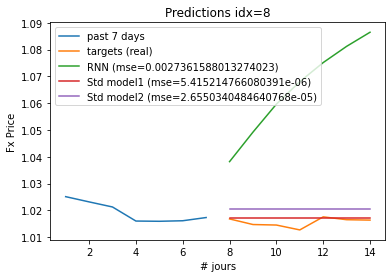

[1.34842002 1.35085999 1.36018002 1.35969996 1.35926997 1.35736
 1.36187994]
[1.34486773 1.34541106 1.34471478 1.34392122 1.34302148 1.34206248
 1.34110693]


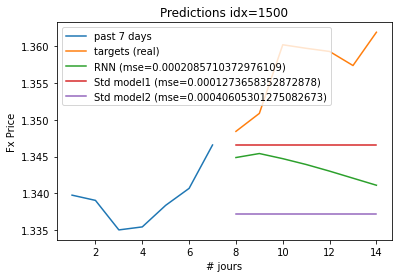

(0.0002085710372976109, 0.0001273658352872878, 0.00040605301275082673, False)

In [ ]:
prediction_n_jours(Xs_test, ys_test, mean, std, n=7, idx=8, display=True, bootstrap=True)
prediction_n_jours(Xs_test, ys_test, mean, std, n=7, idx=1500, display=True, bootstrap=True)

[1.32691001 1.33184003 1.33196997 1.32381999 1.31580996 1.30700004
 1.30903995 1.31526994 1.31173002 1.30304002]
[1.30712509 1.30465004 1.30389266 1.3031054  1.3024061  1.30179937
 1.30114765 1.30055447 1.29994707 1.29935174]


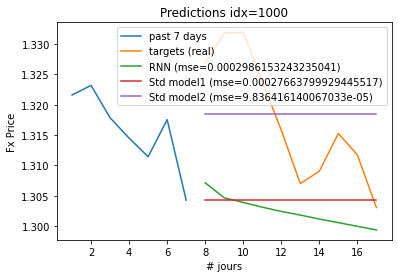

(0.0002986153243235041, 0.00027663799929445517, 9.836416140067033e-05, True)

In [ ]:
prediction_n_jours(Xs_test, ys_test, mean, std, n=10, idx=1000, display=True, bootstrap=True)

### Évaluation de la performance du modèle RNN par rapport à la marche aléatoire

In [ ]:
rnn_mse_all = np.array([])
rnn_direction_all = np.array([])
model1_mse_all = np.array([])
model2_mse_all = np.array([])

X = Xs_test
Y = ys_test
n = 7
display = False
bootstrap = True

for idx in range(7,X.shape[0]-n):
  r_mse, m1_mse, m2_mse, dir = prediction_n_jours(X, Y, mean, std, n=n, idx=idx, display=display, bootstrap=bootstrap)
  rnn_mse_all = np.append(rnn_mse_all,r_mse)
  rnn_direction_all = np.append(rnn_direction_all, dir)
  model1_mse_all = np.append(model1_mse_all,m1_mse)
  model2_mse_all = np.append(model2_mse_all,m2_mse)

rnn_mse_all = rnn_mse_all[~np.isnan(rnn_mse_all)]
model1_mse_all = model1_mse_all[~np.isnan(model1_mse_all)]
model2_mse_all = model2_mse_all[~np.isnan(model2_mse_all)]

print(f'mean rnn MSE = {np.mean(rnn_mse_all)}')
print(f'mean model1 MSE = {np.mean(model1_mse_all)}')
print(f'mean model2 MSE = {np.mean(model2_mse_all)}')
print(f'rnn direction predict accuracy = {np.sum(rnn_direction_all)/np.size(rnn_direction_all)}')

mean rnn MSE = 0.000312607658009799
mean model1 MSE = 0.0001405909348925031
mean model2 MSE = 0.00024079385490623093
rnn direction predict accuracy = 0.5172740179839092


# Conclusion

J'ai réalisé plusieurs tests du modèle RNN pour la prédiction des prix des devises. Pour les prévisions sur 1 jour seulement comme pour celles sur 7 jours, le RNN ne bat pas le modèle de marche aléatoire. 

Concernant son apprentissage, j'ai entraîné le RNN avec 1 devise, puis 2 et enfin 3 devises (en sauvegardant les poids internes). Il a appris successivement sur 1, 2 puis 3 devises. Là encore le RNN ne bat pas la marche aléatoire mais on constate qu'il s'en rapproche de plus en plus en terme d'erreur.

Pourrait-on dire alors que plus on lui apprend avec de nouvelles devises ... plus il "comprend" que la marche aléatoire est la meilleure prévision? Ce point reste à clarifier.

J'ai aussi vérifié combien de fois il prédisait la bonne tendance (hausse ou baisse) ... et on est à 50% en moyenne, ce qui semble confirmer que la marche aléatoire est asymptotiquement la conclusion de son apprentissage.

Les modèles **Long-Short Term Memory** et **Transformer** sont utiles lorsque l'on traite de longues séquences (20 termes et plus) et mettent en œuvre le concept **"d'attention"** c'est à dire sur quels éléments de la séquence il faut porter attention pour prédire la suite (cas de la traduction automatique de texte). Pour des séquences de 7 termes, le RNN est suffisant. Ces modèles seront donc à considérer dans une phase ultérieure du projet.